In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)

import matplotlib.pyplot as plt


In [2]:
df=pd.read_csv('/content/EDA_data.csv')
df.head()

,Latitude,Longitude,Elevation,Slope,Aspect,Curvature,SPI,TWI,TRI,NDVI,LULC,Annual_Rainfall,Drainage_Density,Soil_Texture,Landslide
0,22.645184,92.197626,46,4.077521,310.236359,0.224299,-1.935804,-1.935804,1.987616,0.075623,7.0,57.196407,0.0,4.0,1
1,22.646482,92.197168,41,2.732584,127.874985,0.000000,-3.042220,-3.042220,1.286204,0.086853,7.0,57.211571,0.0,4.0,1
2,22.647297,92.195212,53,2.397054,90.000000,0.672897,-1.935804,-1.935804,1.490712,0.067504,7.0,57.211571,0.0,4.0,1
3,22.646742,92.193913,43,5.756790,265.236359,0.448598,-1.485546,-1.485546,2.748737,0.055501,7.0,57.227306,0.0,4.0,1
4,22.660147,92.155306,60,5.452793,254.744888,0.336448,-1.416456,-1.416456,4.876246,0.169679,7.0,57.192352,0.0,7.0,1


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Latitude          498 non-null    float64
 1   Longitude         498 non-null    float64
 2   Elevation         498 non-null    int64  
 3   Slope             498 non-null    float64
 4   Aspect            498 non-null    float64
 5   Curvature         498 non-null    float64
 6   SPI               498 non-null    float64
 7   TWI               498 non-null    float64
 8   TRI               498 non-null    float64
 9   NDVI              498 non-null    float64
 10  LULC              498 non-null    float64
 11  Annual_Rainfall   498 non-null    float64
 12  Drainage_Density  498 non-null    float64
 13  Soil_Texture      498 non-null    float64
 14  Landslide         498 non-null    int64  
dtypes: float64(13), int64(2)
memory usage: 58.5 KB


**Device Configuration (GPU)**

---



---



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


**Data Preparation**

---



---



In [6]:
# Separate features and target
X = df.drop(columns=['Landslide']).values
y = df['Landslide'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)

X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

# DataLoader
train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True
)


**Bayesian Linear Layer**

---



---



In [7]:
class BayesianLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()

        self.w_mu = nn.Parameter(torch.zeros(out_features, in_features))
        self.w_rho = nn.Parameter(torch.ones(out_features, in_features) * -3)

        self.b_mu = nn.Parameter(torch.zeros(out_features))
        self.b_rho = nn.Parameter(torch.ones(out_features) * -3)

    def forward(self, x):
        w_sigma = torch.log1p(torch.exp(self.w_rho))
        b_sigma = torch.log1p(torch.exp(self.b_rho))

        w = self.w_mu + w_sigma * torch.randn_like(w_sigma)
        b = self.b_mu + b_sigma * torch.randn_like(b_sigma)

        return F.linear(x, w, b)

    def kl_loss(self):
        w_sigma = torch.log1p(torch.exp(self.w_rho))
        b_sigma = torch.log1p(torch.exp(self.b_rho))

        kl_w = -0.5 * torch.sum(
            1 + torch.log(w_sigma**2) - self.w_mu**2 - w_sigma**2
        )
        kl_b = -0.5 * torch.sum(
            1 + torch.log(b_sigma**2) - self.b_mu**2 - b_sigma**2
        )

        return kl_w + kl_b


**Bayesian Deep Neural Network**

---



---



In [8]:
class BayesianDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        self.fc1 = BayesianLinear(input_dim, 64)
        self.fc2 = BayesianLinear(64, 32)
        self.fc3 = BayesianLinear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))

    def kl_loss(self):
        return (
            self.fc1.kl_loss() +
            self.fc2.kl_loss() +
            self.fc3.kl_loss()
        )


**Model, Optimizer**

---



---



In [9]:
model = BayesianDNN(input_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 200


**Training Loop (Bayes-by-Backprop)**

---



---



In [10]:
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()

        preds = model(xb).squeeze()
        bce = F.binary_cross_entropy(preds, yb)
        kl = model.kl_loss() / len(X_train)

        loss = bce + kl
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")


Epoch [20/200], Loss: 232.4721
Epoch [40/200], Loss: 209.3548
Epoch [60/200], Loss: 187.0504
Epoch [80/200], Loss: 165.3878
Epoch [100/200], Loss: 144.4955
Epoch [120/200], Loss: 124.8784
Epoch [140/200], Loss: 106.6210
Epoch [160/200], Loss: 91.1880
Epoch [180/200], Loss: 75.8260
Epoch [200/200], Loss: 64.1476


**Bayesian Prediction (Monte Carlo Sampling)**

---



---



In [11]:
model.eval()
mc_samples = 100

predictions = []

with torch.no_grad():
    for _ in range(mc_samples):
        preds = model(X_test).squeeze()
        predictions.append(preds.cpu().numpy())

predictions = np.array(predictions)

mean_probs = predictions.mean(axis=0)
y_pred = (mean_probs >= 0.5).astype(int)


**Accuracy Metrics**

---



---



In [12]:
acc = accuracy_score(y_test.cpu(), y_pred)
prec = precision_score(y_test.cpu(), y_pred)
rec = recall_score(y_test.cpu(), y_pred)
f1 = f1_score(y_test.cpu(), y_pred)
auc = roc_auc_score(y_test.cpu(), mean_probs)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"AUC-ROC  : {auc:.4f}")


Accuracy : 0.9200
Precision: 0.8704
Recall   : 0.9400
F1-score : 0.9038
AUC-ROC  : 0.9645


**Confusion Matrix**

---



---



In [13]:
cm = confusion_matrix(y_test.cpu(), y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[68  7]
 [ 3 47]]


**ROC Curve Plot**

---



---



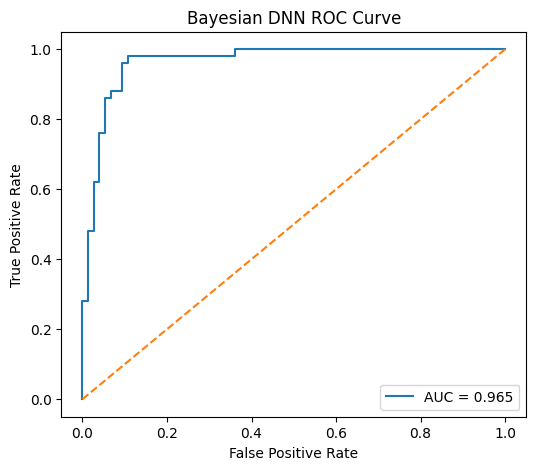

In [14]:
fpr, tpr, _ = roc_curve(y_test.cpu(), mean_probs)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Bayesian DNN ROC Curve")
plt.legend()
plt.show()


**Compute Predictive Mean & Uncertainty**

---



---



In [15]:
# Mean prediction (confidence)
mean_probs = predictions.mean(axis=0)

# Predictive uncertainty (epistemic)
std_probs = predictions.std(axis=0)

# Final class prediction
y_pred = (mean_probs >= 0.5).astype(int)

# True labels
y_true = y_test.cpu().numpy()


**Confidence Histogram**

---



---



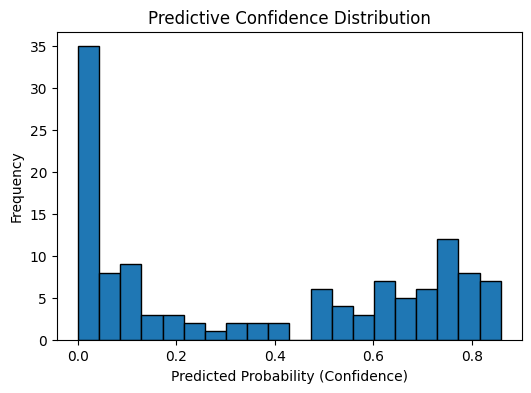

In [16]:
plt.figure(figsize=(6,4))
plt.hist(mean_probs, bins=20, edgecolor='black')
plt.xlabel("Predicted Probability (Confidence)")
plt.ylabel("Frequency")
plt.title("Predictive Confidence Distribution")
plt.show()


**Uncertainty Histogram**

---



---



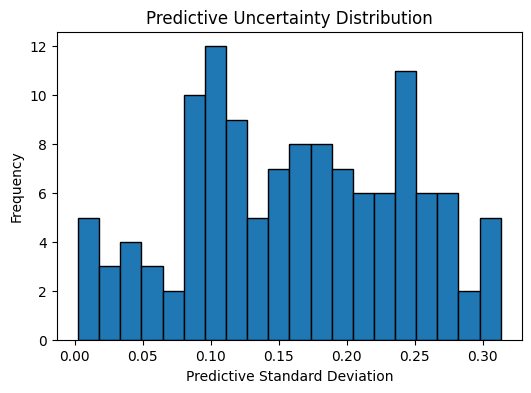

In [17]:
plt.figure(figsize=(6,4))
plt.hist(std_probs, bins=20, edgecolor='black')
plt.xlabel("Predictive Standard Deviation")
plt.ylabel("Frequency")
plt.title("Predictive Uncertainty Distribution")
plt.show()


**Confidence vs Uncertainty**


---


---



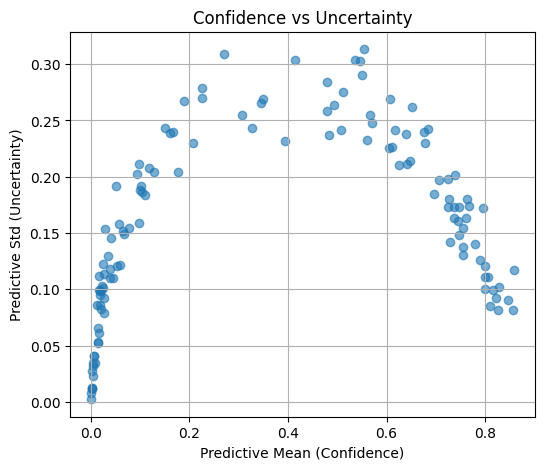

In [18]:
plt.figure(figsize=(6,5))
plt.scatter(mean_probs, std_probs, alpha=0.6)
plt.xlabel("Predictive Mean (Confidence)")
plt.ylabel("Predictive Std (Uncertainty)")
plt.title("Confidence vs Uncertainty")
plt.grid(True)
plt.show()


**Confidence vs Correctness**

---



---



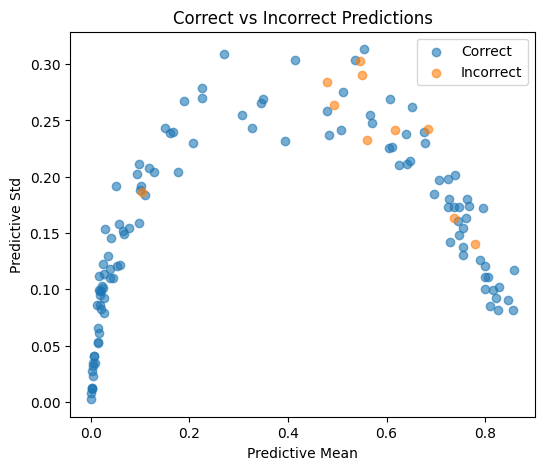

In [19]:
correct = (y_pred == y_true)

plt.figure(figsize=(6,5))
plt.scatter(mean_probs[correct], std_probs[correct], label="Correct", alpha=0.6)
plt.scatter(mean_probs[~correct], std_probs[~correct], label="Incorrect", alpha=0.6)
plt.xlabel("Predictive Mean")
plt.ylabel("Predictive Std")
plt.title("Correct vs Incorrect Predictions")
plt.legend()
plt.show()


**Uncertainty-Aware Confusion Insight**

---



---



In [20]:
threshold = np.percentile(std_probs, 75)  # top 25% most uncertain

high_uncertainty_idx = std_probs >= threshold

print("Accuracy on high-uncertainty samples:",
      accuracy_score(y_true[high_uncertainty_idx],
                     y_pred[high_uncertainty_idx]))

print("Accuracy on low-uncertainty samples:",
      accuracy_score(y_true[~high_uncertainty_idx],
                     y_pred[~high_uncertainty_idx]))


Accuracy on high-uncertainty samples: 0.78125
Accuracy on low-uncertainty samples: 0.967741935483871


**Pickling The Model File **

---



---



In [22]:
import pickle

with open("bayesian_dnn_landslide.pkl", "rb") as f:
    model = pickle.load(f)
